# Extracting events given location and wind thresholds

This code does stuff...

By Claire Krause, October 2017. Python v2. TCRM branch `develop` (but should be applicable to other branches).

**Required inputs**
- This code requires access to TCRM modules (e.g. `database`, `Utilities.`). Make sure the the TCRM directory is in the python path so these modules can be found and imported
- TCRM configuration file. This will tell the code where to look for the hazard and location databases.
- This code assumes that hazard and location databases have already been created. This code does not produce these databases.
- Dict of locations for which you would like to extract events that meet a given wind speed and distance threshold. This dict is defined within the code, and does not need to be imported.

## Set up the notebook imports

In [1]:
%matplotlib inline
from __future__ import print_function, division

In [2]:
import database
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import statsmodels.api as sm
from math import cos, asin, sqrt
import os
from mpl_toolkits.basemap import Basemap

from Utilities.config import ConfigParser
from Utilities.lmomentFit import samlmu, pelgev, pelgpa
from Utilities.track import ncReadTrackData

# Import widgets for interactive notebook
from ipywidgets import interact, fixed
import ipywidgets as widgets

import seaborn as sns
sns.set_context("poster")
sns.set_style("whitegrid")

In [3]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

def loadTrack(trackId):
    trackNum, trackYear = int(trackId.split('-')[0]), int(trackId.split('-')[1])
    trackFile = os.path.join(outputPath, 'tracks', 'tracks.{0:05d}.nc'.format(trackYear))
    tracks = ncReadTrackData(trackFile)
    
    return [t for t in tracks if t.trackId==(trackNum, trackYear)][0]

def getTracks(recs):
    tracks = []
    for rec in recs:
        trackId = rec['eventId']
        track = loadTrack(trackId)
        tracks.append(track)
    return tracks

def plot_relevant_tracks(name_list, speed_thr, dist_thr):
    '''
    Plot tracks that have been identified as meeting a given distance and speed threshold.
    Function adapted after Craig Arthur's 'Extracting events from TCRM database' notebook.
    '''
    locLon = name_list[0][2]
    locLat = name_list[0][3]
    domain = config.geteval('Region', 'gridLimit')
    xx = np.arange(domain['xMin'], domain['xMax'] + 0.1, 0.1)
    yy = np.arange(domain['yMin'], domain['yMax'] + 0.1, 0.1)
    [xgrid, ygrid] = np.meshgrid(xx,yy)
    fig, axes = plt.subplots()
    mapkwargs = dict(llcrnrlon=domain['xMin']-10,
                     llcrnrlat=domain['yMin'],
                     urcrnrlon=domain['xMax'],
                     urcrnrlat=domain['yMax'],
                     resolution='f',
                     projection='merc')
    mapobj = Basemap(ax=axes, **mapkwargs)
    mx, my = mapobj(xgrid, ygrid)
    xmin = mapobj.llcrnrlon
    xmax = mapobj.urcrnrlon
    ymin = mapobj.llcrnrlat
    ymax = mapobj.urcrnrlat

    dx = abs(xmin - xmax)
    dy = abs(ymin - ymax)
    dd = max(dx, dy)
    gr_opts = np.array([30., 10., 5., 4., 2.])
    min_gr = 5
    try:
        dl = gr_opts[np.where((dd/gr_opts) >= min_gr)[0][0]]
    except IndexError:
        dl = 2.

    meridians = np.arange(dl*np.floor(xmin / dl),
                          dl*np.ceil(xmax / dl) + dl, dl)
    parallels = np.arange(dl*np.floor(ymin / dl),
                          dl*np.ceil(ymax / dl) + dl, dl)

    mapobj.drawparallels(parallels, linewidth=0.25,
                         labels=[1, 0, 0, 1], style="italic")
    mapobj.drawmeridians(meridians, linewidth=0.25,
                         labels=[1, 0, 0, 1], style='italic')

    mapobj.fillcontinents(color="#F4B342",
                          lake_color="#BEE8FF",
                          zorder=0)
    mapobj.drawcoastlines(linewidth=.5, color="k")
    mapobj.drawmapboundary(fill_color="#BEE8FF")
    for track in tracks:
        mlon, mlat = mapobj(track.Longitude, track.Latitude)
        mlocLon, mlocLat = mapobj(locLon, locLat)
        mapobj.plot(mlon, mlat, linewidth=1)
        mapobj.plot(mlocLon, mlocLat, marker='o', color='r', markersize=5)

    axes.set_title("TCs passing within {0} km of {1}, with a max gust of at least {2} m/s".format(int(dist_thr), name_list[0][1],
                                                                                                 int(speed_thr)))
    fig.tight_layout()
    plt.show()

## Set up the hazard database instance
Point to the configuration file used to produce the database

In [4]:
configFile = "C:/Users/u37443/TCRM/output/port_hedland/Bodgy_config.ini"
config = ConfigParser()
config.read(configFile)

db = database.HazardDatabase(configFile)
locations = db.getLocations()
locNameList = list(locations['locName'])
outputPath = config.get('Output', 'Path')

No handlers could be found for logger "root"


## Set up the location/s that you would like to analyse

Set up a dict of the locations for which you would like to do the analysis. This dict should include the location name as the keys, and a list of [lat, lon] as the associated data.

In [5]:
locations_to_analyse = {'Broome': [-17.952, 122.232], 'Port Hedland': [-20.310, 118.591], 
                        'Dampier/Karratha': [-20.704, 116.767], 'Exmouth': [-21.943, 114.134], 
                        'Carnarvon': [-24.881, 113.663], 'Geraldton': [-28.781, 114.614], 
                        'Perth': [-31.951, 115.865]}

name_list = []
for locs in locations_to_analyse:
    locsloc = locations_to_analyse[locs]
    listloc = [locations['locLat'], locations['locLon']]    
    temp_list = []
    for num in range(len(listloc[0])):
        temp_list.append(distance(locsloc[0], locsloc[1], listloc[0][num], listloc[1][num]))
    min_dist = temp_list.index(min(temp_list))
    name_list.append(locations[min_dist])
name_list

[(10720, u'Learmonth Airport', 114.08333, -22.23333),
 (11188, u'Karratha Aerodrome Aws', 116.76667, -20.71667),
 (10789, u'Shark Bay Denham', 113.51667, -25.91667),
 (10671, u'Broome Airport', 122.21667, -17.95),
 (10789, u'Shark Bay Denham', 113.51667, -25.91667),
 (10719, u'Carnarvon Airport', 113.66667, -24.86667),
 (10728, u'Port Hedland Bedout Island Aws', 119.1, -19.58333)]

## Find events that meet distance and speed thresholds

The extraction uses the `locationPassageWindSpeed` function within the `database` module in TCRM

In [6]:
# Set the speed and distance thresholds
speed_thr = 60
dist_thr = 50

Just analyse the first location for now...

In [7]:
extreme_events = database.locationPassageWindSpeed(db, str(name_list[0][0]), speed_thr, dist_thr)
tracks = getTracks(extreme_events)

c:\python27\lib\site-packages\mpl_toolkits\basemap\__init__.py:1422: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
c:\python27\lib\site-packages\mpl_toolkits\basemap\__init__.py:2756: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
c:\python27\lib\site-packages\mpl_toolkits\basemap\__init__.py:2765: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


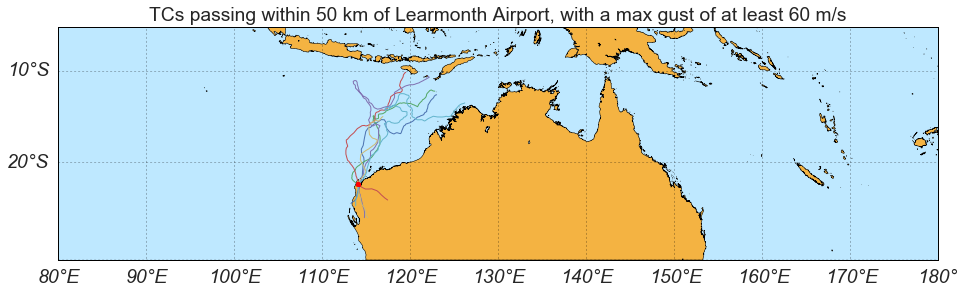

In [8]:
plot_relevant_tracks(name_list, speed_thr, dist_thr)